In [74]:
import numpy as np
from scipy.integrate import odeint
from scipy.special import lambertw

from matplotlib import pyplot as plt

from matplotlib_venn import venn2, venn3, venn3_circles, venn2_circles

import matplotlib.patches as patches

plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'figure.figsize': (8, 6)})

# SIR model

## Analytical & numerical results

/home/alex/miniconda3/envs/GEO/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


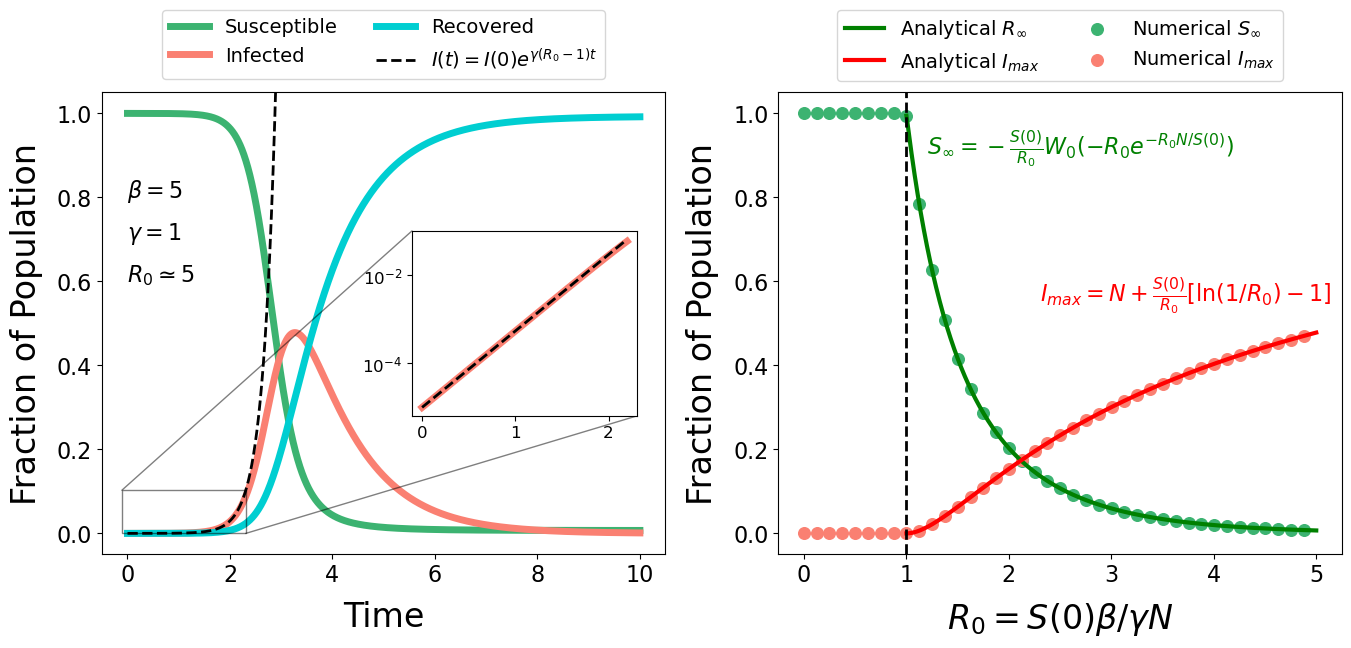

In [75]:
# The SIR model differential equations.
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

def simulate_sir(S0, I0, R0, beta, gamma, N, t):
    y0 = S0, I0, R0
    ret = odeint(deriv, y0, t, args=(N, beta, gamma))
    S, I, R = ret.T
    return S, I, R

def R0_sweep(S0, I0, beta, gamma, N, t, R0s):
    
    S_infs = []
    I_maxs = []
    
    for R0 in R0s:
        beta = R0 * gamma * N / S0
        S, I, R = simulate_sir(S0, I0, R0, beta, gamma, N, t)
        
        S_inf = S[-1]
        I_max = np.max(I)
        
        S_infs.append(S_inf)
        I_maxs.append(I_max)
        
    return np.array(S_infs), np.array(I_maxs)

def analytical_I_max(S0, R0, N):
    
    I_max = N + (S0/R0) * (np.log(1/R0) - 1)
    
    return I_max

def analytical_S_inf(S0, R0, N):
    
    S_inf = -(S0/R0) * lambertw(-R0 * np.exp(-R0 * N/S0))
    
    return S_inf
    
def exponential_approximation(t, I0, gamma, R_0):
    
    I = I0 * np.exp((gamma)*(R_0-1) * t)
    
    return I
    
# Simulation example

N = 100000
I0, R0 = 1, 0
S0 = N - I0 - R0

beta, gamma = 5, 1

tsim = np.linspace(0, 10, 10**4)

S, I, R = simulate_sir(S0, I0, R0, beta, gamma, N, tsim)
    
# Analytical results
t = np.linspace(0, 1000, 10**4)

R0s = np.linspace(0, 5, 1000)

R0s_pos = R0s[R0s > 1]
R0s_neg = R0s[R0s < 1]

S_infs, I_maxs = R0_sweep(S0, I0, beta, gamma, N, t, R0s)

S_infs_analytical = [analytical_S_inf(S0, R0, N)/N for R0 in R0s_pos]
I_maxs_analytical = [analytical_I_max(S0, R0, N)/N for R0 in R0s_pos]

# Figure
fig, ax = plt.subplot_mosaic("""AB""", figsize=(8*2,6))

ns_tsim = 35*100

ax["A"].plot(tsim, S/N, 'mediumseagreen', linewidth=5, label='Susceptible')
ax["A"].plot(tsim, I/N, 'salmon', linewidth=5, label='Infected')
ax["A"].plot(tsim, R/N, 'darkturquoise', linewidth=5, label='Recovered')
ax["A"].plot(tsim[0:ns_tsim], exponential_approximation(tsim[0:ns_tsim], I0, gamma, 5)/N, color='k', linestyle='--', lw=2, label=r'$I(t) = I(0) e^{\gamma(R_0-1) t}$')

ax["A"].set_xlabel('Time', fontsize=24, labelpad=10)
ax["A"].set_ylabel('Fraction of Population', fontsize=24, labelpad=10)

ax["A"].set_ylim(-0.05, 1.05)

# Plot the parameters used and the R0
ax["A"].text(0, 0.8, r'$\beta=5$', fontsize=16, color='k')
ax["A"].text(0, 0.7, r'$\gamma=1$', fontsize=16, color='k')
ax["A"].text(0, 0.6, r'$R_0\simeq5$', fontsize=16, color='k')

ax["A"].legend(ncol=2, fontsize=14, loc='upper center', bbox_to_anchor=(0.5, 1.2))

## inset
axins = ax["A"].inset_axes([0.55, 0.3, 0.4, 0.4])

ns_tsim = 22*100

axins.plot(tsim[0:ns_tsim], I[0:ns_tsim]/N, 'salmon', linewidth=5, label='Infected')
axins.plot(tsim[0:ns_tsim], exponential_approximation(tsim[0:ns_tsim], I0, gamma, 5)/N, color='k', linestyle='--', lw=2)

axins.set_yscale("log")

# change tick size
axins.tick_params(axis='both', which='major', labelsize=12)

ax["A"].indicate_inset_zoom(axins, edgecolor="black")

sample = 25

ax["B"].plot(R0s_pos, S_infs_analytical, color="green", lw=3, label=r'Analytical $R_\infty$')
ax["B"].plot(R0s_pos, I_maxs_analytical, color="r", lw=3, label=r'Analytical $I_{max}$')

ax["B"].axvline(1, color='k', linestyle='--', lw=2)

ax["B"].scatter(R0s[0:-1:sample], S_infs[0:-1:sample]/N, color="mediumseagreen", marker="o", s=70, label=r'Numerical $S_\infty$')
ax["B"].scatter(R0s[0:-1:sample], I_maxs[0:-1:sample]/N, color="salmon", marker="o", s=70, label=r'Numerical $I_{max}$')

ax["B"].set_xlabel(r'$R_0=S(0)\beta/\gamma N$', fontsize=24, labelpad=10)
ax["B"].set_ylabel('Fraction of Population', fontsize=24, labelpad=10)

# plot the analytical formulas
ax["B"].text(1.2, 0.9, r'$S_\infty = -\frac{S(0)}{R_0} W_0(-R_0 e^{-R_0 N/S(0)})$', fontsize=16, color='green')
ax["B"].text(2.3, 0.55, r'$I_{max} = N + \frac{S(0)}{R_0} \left[\ln(1/R_0) - 1\right]$', fontsize=16, color='red')

ax["B"].legend(ncol=2, fontsize=14, loc='upper center', bbox_to_anchor=(0.5, 1.2))

plt.savefig("SIR_model_analysis.pdf", dpi=300, bbox_inches='tight')

# Ecological niche theory

Text(0.5, 1.0, 'BAM framework')

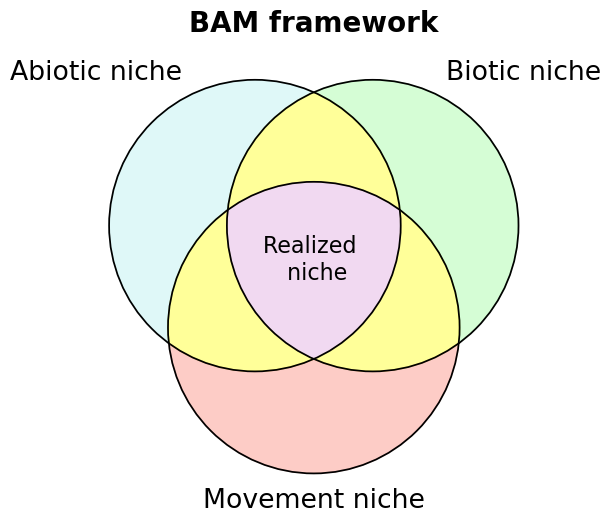

In [77]:
fig, ax = plt.subplots(1, 1, figsize=(16, 6))

# Make a Basic Venn
v = venn3(subsets=(1, 1, 1, 1, 1, 1, 1), set_labels = ('A', 'B', 'C'))

# Custom it
v.get_patch_by_id('100').set_color('paleturquoise')
v.get_patch_by_id('010').set_color('palegreen')
v.get_patch_by_id('001').set_color('salmon')

# v.get_label_by_id('100').set_text('Grinnellian \n niche')
# v.get_label_by_id('110').set_text('Hutchinsonian \n niche')
# v.get_label_by_id('010').set_text('Eltonian \n niche')
v.get_label_by_id('100').set_text('')
v.get_label_by_id('110').set_text('')
v.get_label_by_id('010').set_text('')
v.get_label_by_id('101').set_text('')
v.get_label_by_id('011').set_text('')
v.get_label_by_id('001').set_text('')

v.get_patch_by_id('101').set_color('yellow')
v.get_patch_by_id('011').set_color('yellow')
v.get_patch_by_id('110').set_color('yellow')

v.get_patch_by_id('111').set_color('plum')

v.get_label_by_id('111').set_text('Realized \n niche')

v.get_label_by_id('A').set_text('Abiotic niche')
v.get_label_by_id('B').set_text('Biotic niche')
v.get_label_by_id('C').set_text('Movement niche')

c = venn3_circles(subsets=(1, 1, 1, 1, 1, 1, 1), linestyle='-', linewidth=1.25, color='black')
 
# Add title and annotation
plt.title("BAM framework", fontsize=20, fontweight='bold', color='black', pad=10)

#plt.savefig('BAM_framework.pdf', dpi=300, bbox_inches='tight')

Text(0.5, 1.0, 'Historical perspective')

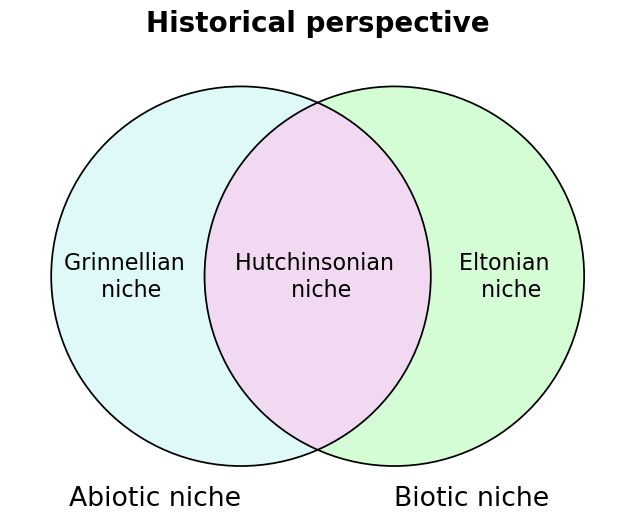

In [78]:
plt.figure(figsize=(8, 6))

# Make a Basic Venn
v = venn2(subsets=(1, 1, 1), set_labels = ('A', 'B'))

v.get_patch_by_id('10').set_color('paleturquoise')
v.get_patch_by_id('01').set_color('palegreen')

v.get_label_by_id('10').set_text('Grinnellian \n niche')
v.get_label_by_id('11').set_text('Hutchinsonian \n niche')
v.get_label_by_id('01').set_text('Eltonian \n niche')

v.get_patch_by_id('11').set_color('plum')

v.get_label_by_id('A').set_text('Abiotic niche')
v.get_label_by_id('B').set_text('Biotic niche')

c = venn2_circles(subsets=(1, 1, 1), linestyle='-', linewidth=1.25, color='black')
 
# Add title and annotation
plt.title("Historical perspective", fontsize=20, fontweight='bold', color='black', pad=10)

#plt.savefig('Historical_niches.pdf', dpi=300, bbox_inches='tight')

# SDMs

In [ ]:
# packages
import elapid as ela

import rasterio as rio
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import metrics
import warnings

import contextily as ctx

# paths
https = "https://earth-chris.github.io/images/research"
vector = f"{https}/ariolimax-buttoni.gpkg"
raster_names = [
    "ca-cloudcover-mean.tif",
    "ca-cloudcover-stdv.tif",
    "ca-leafareaindex-mean.tif",
    "ca-leafareaindex-stdv.tif",
    "ca-surfacetemp-mean.tif",
    "ca-surfacetemp-stdv.tif",
]
rasters = [f"{https}/{raster}" for raster in raster_names]
labels = [raster[3:-4] for raster in raster_names]

# preferences
%matplotlib inline
#mpl.style.use('ggplot')
warnings.filterwarnings("ignore")

print(f"Notebook last run with elapid version {ela.__version__}")

# read the presence data, draw background point samples
presence = gpd.read_file(vector)
background = ela.sample_raster(rasters[0], count=10_000)

# merge datasets and read the covariates at each point location
merged = ela.stack_geodataframes(presence, background, add_class_label=True)
annotated = ela.annotate(merged, rasters, drop_na=True, quiet=True)

# split the x/y data
x = annotated.drop(columns=['class', 'geometry'])
y = annotated['class']

# train the model
model = ela.MaxentModel(transform='cloglog', beta_multiplier=2.0)
model.fit(x, y)

# evaluate training performance
ypred = model.predict(x)
auc = metrics.roc_auc_score(y, ypred)
print(f"Training AUC score: {auc:0.3f}")

# save the fitted model to disk
ela.save_object(model, 'demo-maxent-model.ela')

# write the model predictions to disk
output_raster = 'demo-maxent-predictions.tif'
ela.apply_model_to_rasters(model, rasters, output_raster, quiet=True)

# and read into memory
with rio.open(output_raster, 'r') as src:
    pred = src.read(1, masked=True)
    
fig, ax = plt.subplot_mosaic("""AA
                             BC""", figsize=(12, 6*2))

background_f = background.to_crs(epsg=4326)
presence_f = presence.to_crs(epsg=4326)

presence_f.plot(ax=ax["A"], color='red', markersize=4, zorder=3)

ax['A'].set_ylim(20.0, 50)
ax['A'].set_xlim(-126, -65)

ax['A'].set_axis_off()

ctx.add_basemap(ax["A"], crs=presence_f.crs, source=ctx.providers.OpenTopoMap, zoom=4, alpha=0.7) #ctx.providers.OpenStreetMap.Mapnik, ctx.providers.Esri.WorldStreetMap

handles = [mpl.lines.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label=r'$\it{Ariolimax} \ \it{buttoni}$')]

ax['A'].legend(handles=handles, loc='upper right', fontsize=14)

# # inset to data
# axins = ax['A'].inset_axes([0.1, 0.5, 0.6, 0.4])

# axins.set_xticks([])
# axins.set_yticks([])

# plot the data
background_f.plot(ax=ax['B'], color='k', markersize=1, alpha=0.2)
presence_f.plot(ax=ax['B'], color='red', markersize=4)
ctx.add_basemap(ax['B'], crs=presence_f.crs, source=ctx.providers.OpenStreetMap.Mapnik, zoom=6)

ax['B'].set_axis_off()

## custom legend
handles = [mpl.lines.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, label='Presence'),
              mpl.lines.Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=8, label='Background')]

ax['B'].legend(handles=handles, loc='upper right', fontsize=14)

# plot the model predictions
cax = ax["C"].imshow(pred, vmin=0, vmax=1, cmap='Spectral_r', extent=src.bounds, origin='upper')

cbar = plt.colorbar(cax, ax=ax['C'], orientation='vertical', label='Suitability')

# fontsize of colorbar label
cbar.ax.yaxis.label.set_fontsize(12)

ax['C'].set_axis_off()

plt.subplots_adjust(wspace=0.1, hspace=0.1)

# label subplots
for label, ax in ax.items():
    
    if label == 'A':
        ax.text(0.05, 0.9, "({})".format(label.lower()), fontsize=22, fontweight='bold', ha='center', transform=ax.transAxes)
        
    elif label == 'B':
        ax.text(0.05, 1.03, "({})".format(label.lower()), fontsize=22, fontweight='bold', ha='center', transform=ax.transAxes)
        
    elif label == 'C':
        ax.text(0.05, 1.1, "({})".format(label.lower()), fontsize=22, fontweight='bold', ha='center', transform=ax.transAxes)
        
plt.savefig('demo-maxent-predictions.png', dpi=300, bbox_inches='tight')